
<h1>Problem Description</h1>

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

---

You should create a function called predict_message that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the SMS Spam Collection dataset (https://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.

<h1>Solution</h1>

Import libraries

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
tfds.disable_progress_bar()

Get data files

In [ ]:

!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2023-07-04 19:05:53--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.01s   

2023-07-04 19:05:53 (24.9 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2023-07-04 19:05:53--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==============

In [ ]:
train_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
train_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


Test data frame

In [ ]:
test_df = pd.read_csv(test_file_path, sep="\t", header=None, names=["type", "msg"])
test_df.dropna()
train_df.head()

,type,msg
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


Prepare levels for training

In [ ]:
train_df["type"] = pd.factorize(train_df["type"])[0]
test_df["type"] = pd.factorize(test_df["type"])[0]

In [ ]:
train_df.head()

,type,msg
0,0,i am in hospital da. . i will return home in e...
1,0,"not much, just some textin'. how bout you?"
2,0,i probably won't eat at all today. i think i'm...
3,0,don‘t give a flying monkeys wot they think and...
4,0,who are you seeing?


In [ ]:
train_labels =  train_df["type"].values
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["msg"].values, train_labels)
)

In [ ]:
test_labels =  test_df["type"].values
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["msg"].values, test_labels)
)
test_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

This step is important. It's not only about batching the data sets, but also reshape it to make it works when fitting the model. Otherwise, we will get incompatible layers errors: expecting ndim=3, got ndim=2.


In [ ]:
BUFFER_SIZE = 100
BATCH_SIZE = 32
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Create a TextVectorization layer for our model

In [ ]:
vec = TextVectorization(
    output_mode='int',
    max_tokens=1000,
    output_sequence_length=1000,
)

vec.adapt(train_ds.map(lambda text, label: text))

Let's show the vocabulary that our vectorizer has learned.

In [ ]:
vocab = np.array(vec.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'to', 'you', 'a', 'the', 'u', 'and', 'is', 'in',
       'me', 'my', 'your', 'for', 'have', 'it', 'of', 'call', 'that'],
      dtype='<U16')

Create the model

In [ ]:
model = tf.keras.Sequential([
    vec,
    tf.keras.layers.Embedding(
        len(vec.get_vocabulary()),
        64,
        mask_zero=True,
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
)

Train the model against our data sets.

In [ ]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    validation_steps=30,
    epochs=10,
)

Epoch 1/10
44/44 [==============================] - 196s 4s/step - loss: 0.6814 - accuracy: 0.8657 - val_loss: 0.6641 - val_accuracy: 0.8604
Epoch 2/10
44/44 [==============================] - 188s 4s/step - loss: 0.6297 - accuracy: 0.8657 - val_loss: 0.5768 - val_accuracy: 0.8604
Epoch 3/10
44/44 [==============================] - 169s 4s/step - loss: 0.5256 - accuracy: 0.8657 - val_loss: 0.4948 - val_accuracy: 0.8604
Epoch 4/10
44/44 [==============================] - 169s 4s/step - loss: 0.4531 - accuracy: 0.8657 - val_loss: 0.4214 - val_accuracy: 0.8604
Epoch 5/10
44/44 [==============================] - 166s 4s/step - loss: 0.3752 - accuracy: 0.8657 - val_loss: 0.3248 - val_accuracy: 0.8604
Epoch 6/10
44/44 [==============================] - 168s 4s/step - loss: 0.2595 - accuracy: 0.8657 - val_loss: 0.1877 - val_accuracy: 0.8604
Epoch 7/10
44/44 [==============================] - 167s 4s/step - loss: 0.1560 - accuracy: 0.8843 - val_loss: 0.1227 - val_accuracy: 0.9708
Epoch 8/10
44

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)

44/44 [==============================] - 42s 951ms/step - loss: 0.0535 - accuracy: 0.9856


In [ ]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.05354047566652298
Test Accuracy: 0.9856321811676025


Plot the accuracy and loss metrics

In [ ]:
# Create a helper function to plot
def plot_graphs(h, metric):
    plt.plot(h.history[metric])
    plt.plot(h.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

(0.0, 0.7126738810911775)

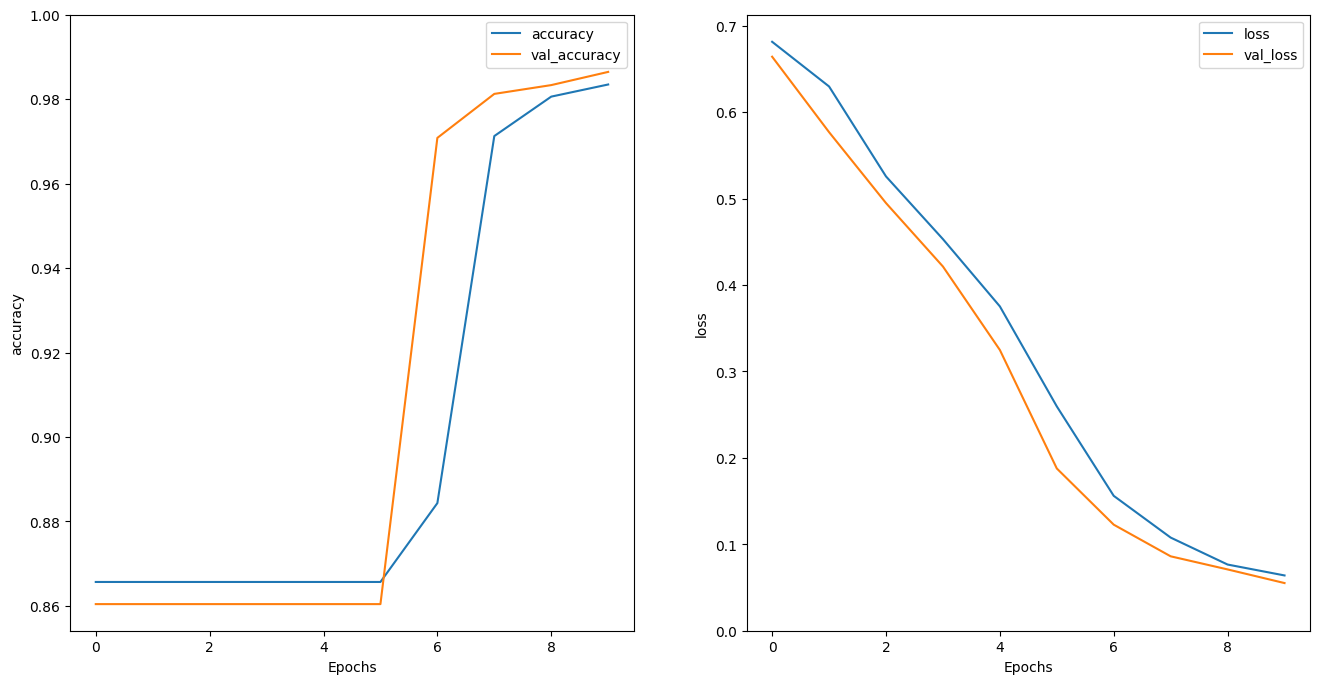

In [ ]:
# Plot the graphs
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
h = history.history
print(h['loss'])
print(h['val_loss'])
print(h['accuracy'])
print(h['val_accuracy'])

[0.6813624501228333, 0.6296671032905579, 0.5255936980247498, 0.4530588686466217, 0.37523847818374634, 0.259530633687973, 0.15604402124881744, 0.10775481909513474, 0.07656080275774002, 0.0639517530798912]
[0.6641029119491577, 0.5768091082572937, 0.49477618932724, 0.4213663637638092, 0.3248105049133301, 0.18771086633205414, 0.12269840389490128, 0.08608173578977585, 0.07091746479272842, 0.05513383075594902]
[0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8656609058380127, 0.8843390941619873, 0.9712643623352051, 0.9806034564971924, 0.983476996421814]
[0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.8604166507720947, 0.9708333611488342, 0.981249988079071, 0.9833333492279053, 0.9864583611488342]


In [ ]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  ps = model.predict([pred_text])
  print(ps)
  p = ps[0][0]
  return [p, "ham" if p <0.5 else "spam"]

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 0s 446ms/step
[[-4.3195868]]
[-4.3195868, 'ham']


Test

In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You haven't passed yet. Keep trying.")
  else:
    print("You passed the challenge. Great job!")

test_predictions()


1/1 [==============================] - 0s 441ms/step
[[-4.3195868]]
1/1 [==============================] - 0s 246ms/step
[[-0.09663094]]
1/1 [==============================] - 0s 283ms/step
[[-9.498313]]
1/1 [==============================] - 0s 243ms/step
[[0.14832237]]
1/1 [==============================] - 0s 236ms/step
[[1.5491161]]
1/1 [==============================] - 0s 316ms/step
[[-7.8023777]]
1/1 [==============================] - 1s 551ms/step
[[-9.162452]]
You passed the challenge. Great job!
